In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/intermediate-dataset/prev_approved_cash_loans.csv
/kaggle/input/intermediate-dataset/curr_cash_loans.csv
/kaggle/input/intermediate-dataset/de_duplicated_data.csv
/kaggle/input/cleaned-dataset/prepaid.csv
/kaggle/input/cleaned-dataset/late_but_repaid.csv
/kaggle/input/cleaned-dataset/features.csv
/kaggle/input/cleaned-dataset/profit.csv
/kaggle/input/cleaned-dataset/defaulted.csv


In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
import sklearn as sk
from pathlib import Path

input_dir = Path('/kaggle/input/cleaned-dataset')
matrix = pd.read_csv(input_dir / 'features.csv')

features = list(set(matrix.columns) - set(['TARGET', 'SK_ID_CURR']))

X = matrix.copy()[features]
y = matrix.copy().TARGET

### Double check for NAs

In [4]:
X.isnull().sum() #check for NAs

QUICK_RATIO                   0
FLAG_OWN_REALTY               0
NAME_EDUCATION_TYPE           0
NAME_HOUSING_TYPE             0
MEAN_DPD                      0
FLAG_EMP_PHONE                0
FLAG_CONT_MOBILE              0
LIVE_CITY_NOT_WORK_CITY       0
REG_CITY_NOT_WORK_CITY        0
PREPAID_FREQ                  0
REG_CITY_NOT_LIVE_CITY        0
CODE_GENDER                   0
WEIGHTED_AVR_INTEREST_RATE    0
AVG_LATE_PAYMENT              0
NAME_INCOME_TYPE              0
dtype: int64

In [5]:
X.dtypes

QUICK_RATIO                   float64
FLAG_OWN_REALTY                object
NAME_EDUCATION_TYPE            object
NAME_HOUSING_TYPE              object
MEAN_DPD                      float64
FLAG_EMP_PHONE                  int64
FLAG_CONT_MOBILE                int64
LIVE_CITY_NOT_WORK_CITY         int64
REG_CITY_NOT_WORK_CITY          int64
PREPAID_FREQ                  float64
REG_CITY_NOT_LIVE_CITY          int64
CODE_GENDER                    object
WEIGHTED_AVR_INTEREST_RATE    float64
AVG_LATE_PAYMENT              float64
NAME_INCOME_TYPE               object
dtype: object

### Converting Strings to Numeric Types
1. Use 1 hot encoding.

In [6]:
print(X.CODE_GENDER.unique())
print(X.NAME_INCOME_TYPE.unique())
print(X.NAME_HOUSING_TYPE.unique())
print(X.FLAG_OWN_REALTY.unique())
print(X.NAME_EDUCATION_TYPE.unique())

['F' 'M']
['Commercial associate' 'Pensioner' 'Working' 'State servant'
 'Maternity leave' 'Student' 'Unemployed']
['House / apartment' 'Municipal apartment' 'With parents'
 'Office apartment' 'Rented apartment' 'Co-op apartment']
['N' 'Y']
['Secondary / secondary special' 'Higher education' 'Lower secondary'
 'Academic degree' 'Incomplete higher']


In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

categorical_cols = ['CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_HOUSING_TYPE', 
                 'FLAG_OWN_REALTY', 'NAME_EDUCATION_TYPE']

transformer_one_hot = (OneHotEncoder(drop='first'), categorical_cols) #2x check this

transformer = make_column_transformer(
               transformer_one_hot, remainder='passthrough'
            )

encoded = transformer \
            .fit_transform(X)

encoded_df = pd.DataFrame(encoded, \
                          columns=transformer.get_feature_names())
print(X.columns)
print(encoded_df.columns)

Index(['QUICK_RATIO', 'FLAG_OWN_REALTY', 'NAME_EDUCATION_TYPE',
       'NAME_HOUSING_TYPE', 'MEAN_DPD', 'FLAG_EMP_PHONE', 'FLAG_CONT_MOBILE',
       'LIVE_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_WORK_CITY', 'PREPAID_FREQ',
       'REG_CITY_NOT_LIVE_CITY', 'CODE_GENDER', 'WEIGHTED_AVR_INTEREST_RATE',
       'AVG_LATE_PAYMENT', 'NAME_INCOME_TYPE'],
      dtype='object')
Index(['onehotencoder__x0_M', 'onehotencoder__x1_Maternity leave',
       'onehotencoder__x1_Pensioner', 'onehotencoder__x1_State servant',
       'onehotencoder__x1_Student', 'onehotencoder__x1_Unemployed',
       'onehotencoder__x1_Working', 'onehotencoder__x2_House / apartment',
       'onehotencoder__x2_Municipal apartment',
       'onehotencoder__x2_Office apartment',
       'onehotencoder__x2_Rented apartment', 'onehotencoder__x2_With parents',
       'onehotencoder__x3_Y', 'onehotencoder__x4_Higher education',
       'onehotencoder__x4_Incomplete higher',
       'onehotencoder__x4_Lower secondary',
       'onehotencoder

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### Logistic Regression Trial 1
1. Fit a logistic regression model without hyper-parameter tuning and cross-validation.

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardised_df = scaler.fit_transform(encoded_df)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( \
    standardised_df, y, test_size=0.2, stratify=y, random_state=42)

In [10]:
from sklearn.linear_model import LogisticRegression

def init_log_reg(params: dict):
    penalty = params['PENALTY']
    class_weight = params['CLASS_WEIGHT']
    solver = params['SOLVER']
    multi_class = params['MULTI_CLASS']
    C = params['C']
    max_iter = params['MAX_ITER']
    
    return LogisticRegression(
        penalty=penalty, class_weight=class_weight, solver=solver, 
        multi_class=multi_class)

params = {'PENALTY': 'l1', 'CLASS_WEIGHT': {1: 10, 0:2}, 
          'SOLVER': 'saga', 'MULTI_CLASS': 'ovr', 'C': 0.01, 'MAX_ITER': 100000}

log_reg = init_log_reg(params).fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

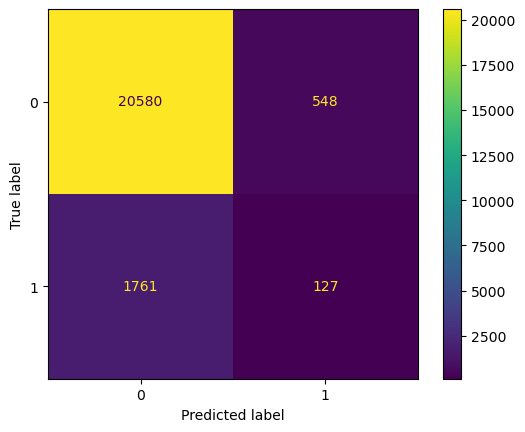

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm =  confusion_matrix(y_test, y_pred, labels=log_reg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot()

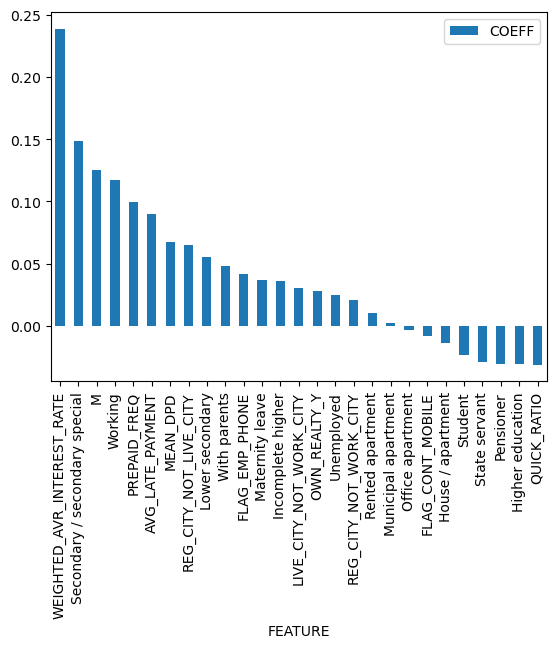

In [12]:
def plot_feature_impt(coeffs, features):
    coeff_dict = {'COEFF': [], 'FEATURE': []}
    
    for ith_coeff, ith_feature in zip(coeffs, features):
        if 'onehotencoder' in ith_feature:
            ith_feature = ith_feature.split('_')[-1]
            if ith_feature in ['N', 'Y']:
                ith_feature = f'OWN_REALTY_{ith_feature}'
        
        coeff_dict['COEFF'].append(ith_coeff)
        coeff_dict['FEATURE'].append(ith_feature)
    
    df = pd.DataFrame(coeff_dict).sort_values(by='COEFF', ascending=False)
    df.plot.bar(x='FEATURE', y='COEFF')
    
features = encoded_df.columns
plot_feature_impt(log_reg.coef_[0], features)

In [13]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
print(round(accuracy_score(y_test, y_pred), 2))
print(round(f1_score(y_test, y_pred), 2))
print(round(recall_score(y_test, y_pred), 2))
print(round(precision_score(y_test, y_pred), 2))

0.9
0.1
0.07
0.19


### Logistic Regression: Precision-Recall Curve and Generalisation Error.
1. Due to imbalanced ratio of Default:Non-Default, accuracy score is misleading although it is high.
2. Do Grid-Search CV to hypertune Class Weights and Lasso Penalty.
3. Based on optimal hyperparameters, compute the Precision-Recall Curve to find optimal thresholding.

In [14]:
from sklearn.model_selection import GridSearchCV

log_reg = LogisticRegression(penalty='l1', solver='saga')
hyper_params = {
    'class_weight': [{1: w} for w in range(10,15)],
    'C': np.linspace(start = 4, stop = 5, num = 5),
    
}

validator = GridSearchCV(
    estimator=log_reg,
    param_grid=hyper_params,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=0
)

validator.fit(X_train, y_train)
print(validator.best_params_)
print(validator.best_score_) #an improvement over f1_score without hyper-parameter tuning.

{'C': 4.0, 'class_weight': {1: 10}}
0.19969601287782582


### Selecting Optimal Thresholding via Precision Recall Curve.
1. First start with hypertuned logistic regression. Then compute the Precision Recall Curve for logistic regression.
2. Perform hyper-parameter tuning. This time, select between logistic regression and random forest.
3. Then compute the Precision Recall Curve for the optimal model in part 2.

In [15]:
log_reg_hypertuned = LogisticRegression(
    penalty='l1', solver='saga', C=4.0, class_weight={1:10})

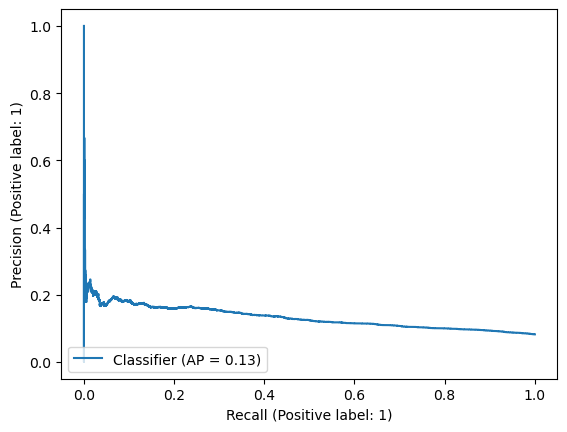

In [16]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
import matplotlib.pyplot as plt

log_reg_hypertuned.fit(X_train, y_train)
y_pred = log_reg_hypertuned.predict_proba(X_test)[:, 1]

PrecisionRecallDisplay.from_predictions(y_test, y_pred)
plt.show()

In [17]:
pr, rc, threshold = precision_recall_curve(y_test, y_pred)

optimal_threshold = sorted(list(zip(np.abs(pr - rc), threshold)), key=lambda i: i[0], reverse=False)[0][1]

prc_predictions = [1 if i >= optimal_threshold else 0 for i in y_pred]
print(f1_score(y_test, prc_predictions))
print(optimal_threshold)

0.1620762711864407
0.6098361276709224


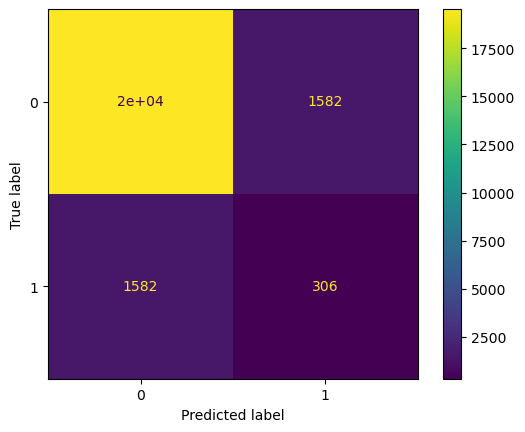

In [18]:
cm =  confusion_matrix(y_test, prc_predictions, labels=log_reg_hypertuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg_hypertuned.classes_)
disp.plot()

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearnex import patch_sklearn
patch_sklearn()

log_reg = LogisticRegression(penalty='l1', random_state=42, solver='saga')
hyper_params_log_reg = {
    'classifier__class_weight': [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}],
    'classifier__C': [10**-2, 10**-1, 10**0, 10**1, 10**2],
    'classifier': [log_reg]
}

rfc = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=42)
hyper_params_rfc = {
    'classifier__class_weight': [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}],
    'classifier__n_estimators' : [10, 50, 100, 250],
    'classifier': [rfc]
}

pipeline = Pipeline([('classifier', log_reg)])

validator = GridSearchCV(
    estimator=pipeline,
    param_grid=[hyper_params_log_reg, hyper_params_rfc],
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=0
)

validator.fit(X_train, y_train)
print(validator.best_params_)
print(validator.best_score_) #may need to hypertune max_iter again

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/l

{'classifier': LogisticRegression(C=1, class_weight={0: 1, 1: 10}, penalty='l1',
                   random_state=42, solver='saga'), 'classifier__C': 1, 'classifier__class_weight': {0: 1, 1: 10}}
0.1997160608236716


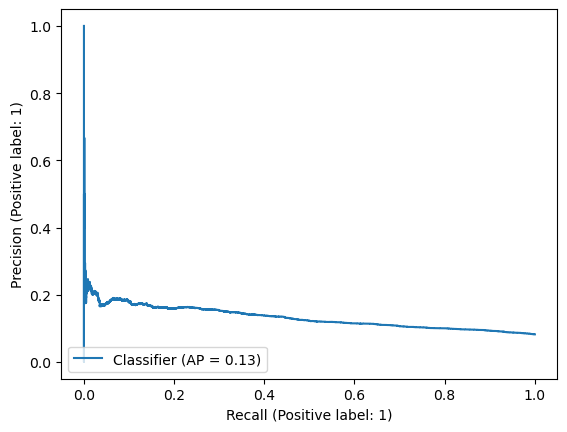

In [20]:
log_reg_hypertuned_2 = LogisticRegression(
    penalty='l1', solver='saga', C=0.01, class_weight={1:10, 0:1})

log_reg_hypertuned_2.fit(X_train, y_train)
y_pred_2 = log_reg_hypertuned_2.predict_proba(X_test)[:, 1]

PrecisionRecallDisplay.from_predictions(y_test, y_pred_2)
plt.show()#precision will always be terrible than recall because: marginal distribution is dominated by non-defaulters.

In [21]:
pr_2, rc_2, threshold_2 = precision_recall_curve(y_test, y_pred_2)

optimal_threshold_2 = sorted(list(zip(np.abs(pr_2 - rc_2), threshold_2)), key=lambda i: i[0], reverse=False)[0][1]

prc_predictions_2 = [1 if i >= optimal_threshold_2 else 0 for i in y_pred_2]
print(f1_score(y_test, prc_predictions_2))
print(optimal_threshold_2)

0.16366525423728814
0.6075480681849331


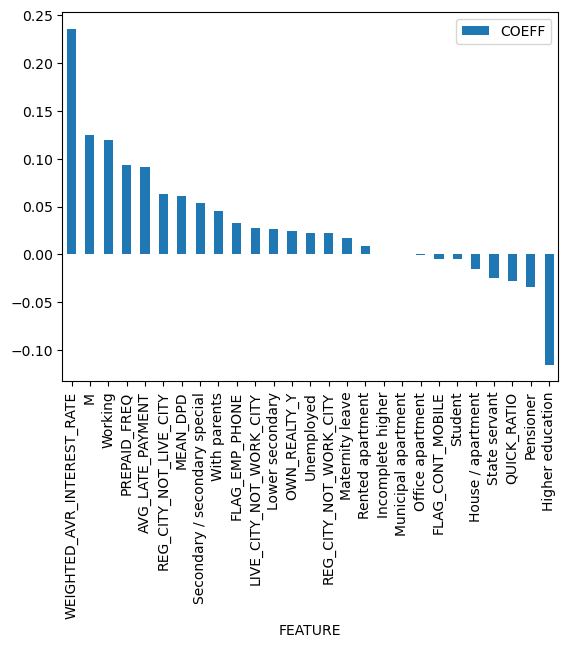

In [22]:
def plot_feature_impt(coeffs, features):
    coeff_dict = {'COEFF': [], 'FEATURE': []}
    
    for ith_coeff, ith_feature in zip(coeffs, features):
        if 'onehotencoder' in ith_feature:
            ith_feature = ith_feature.split('_')[-1]
            if ith_feature in ['N', 'Y']:
                ith_feature = f'OWN_REALTY_{ith_feature}'
        
        coeff_dict['COEFF'].append(ith_coeff)
        coeff_dict['FEATURE'].append(ith_feature)
    
    df = pd.DataFrame(coeff_dict).sort_values(by='COEFF', ascending=False)
    df.plot.bar(x='FEATURE', y='COEFF')
    
features = encoded_df.columns
plot_feature_impt(log_reg_hypertuned_2.coef_[0], features)

### Computing The Expected Loss Due to Default.
Using the L1 Logistic Regression from hypertuning 2 and its optimal threshold, compute 2 things:
1. For SK_ID_CURR, get their probability of default (PD) with logistic regression.
2. Obtain their current credit amount from de_duplicated_df.
3. Compute the Expected Loss Due to Default by taking the product of PD and current credit amount. Note that this assumes the recovery rate of the principal is 0.

In [23]:
de_duplicated_df = pd.read_csv('/kaggle/input/intermediate-dataset/de_duplicated_data.csv')
de_duplicated_df.columns

Index(['Unnamed: 0', 'SK_ID_PREV', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT', 'TOTAL_REPAID_PER_INSTAL',
       'SK_ID_CURR', 'NAME_PRODUCT_TYPE', 'NAME_YIELD_GROUP', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE', 'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
       'CNT_PAYMENT', 'INTEREST_RATE', 'TARGET', 'CODE_GENDER',
       'DAYS_ID_PUBLISH', 'CURR_AMT_CREDIT', 'CURR_AMT_ANNUITY',
       'NAME_CONTRACT_TYPE', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE',
       'DAYS_EMPLOYED', 'FLAG_OWN_REALTY', 'NAME_HOUSING_TYPE',
       'NAME_EDUCATION_TYPE', 'LIVE_CITY_NOT_WORK_CITY',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'FLAG_EMAIL',
       'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'],
      dtype='object')

In [24]:
cols_to_keep = ['SK_ID_CURR', 'CURR_AMT_CREDIT']
principal_for_curr_loans = de_duplicated_df[de_duplicated_df.SK_ID_CURR.isin(matrix.SK_ID_CURR)] \
                            .filter(cols_to_keep) \
                            .drop_duplicates()

In [25]:
prob_default = log_reg_hypertuned_2.predict_proba(standardised_df)[:, 1]
prob_default

array([0.50855537, 0.40237186, 0.4613264 , ..., 0.82223333, 0.88324973,
       0.87013013])

In [26]:
principal_for_curr_loans['PD'] = prob_default
principal_for_curr_loans['Expected Loss Due to Default'] = principal_for_curr_loans['PD'] * principal_for_curr_loans['CURR_AMT_CREDIT'] 
principal_for_curr_loans.head()

,SK_ID_CURR,CURR_AMT_CREDIT,PD,Expected Loss Due to Default
0,198678,1314117.0,0.508555,668301.258713
12,277601,254700.0,0.402372,102484.112467
23,198771,1159515.0,0.461326,534914.884000
33,217553,277969.5,0.613992,170670.976014
48,330786,263686.5,0.466709,123064.872149


In [27]:
print(f"Expected Loss Due to Default with 0 Recovery Rate is: {principal_for_curr_loans['Expected Loss Due to Default'].sum()}")
print(f"Total Principal Loan out is: {principal_for_curr_loans['CURR_AMT_CREDIT'].sum()}")

Expected Loss Due to Default with 0 Recovery Rate is: 31673511012.39492
Total Principal Loan out is: 70058030220.0


In [28]:
principal_for_curr_loans['CURR_AMT_CREDIT'].sum() / 10**9

70.05803022

In [29]:
principal_for_curr_loans['Expected Loss Due to Default'].sum() / 10**9

31.673511012394922

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter